# Time dependent arrivals via thinning

This notebook provides an overview of how to use the `time_dependent.NSPPThinning` class.  

Thinning is an acceptance-rejection approach to sampling inter-arrival times (IAT) from a time dependent distribution where each time period follows its own exponential distribution.

There are two random variables employed in sampling: an exponential distribution (used to sample IAT) and a uniform distibution (used to accept/reject samples).

All IATs are sampled from an Exponential distribution with the highest arrival rate (most frequent). These arrivals are then rejected (thinned) proportional to the ratio of the current arrival rate to the maximum arrival rate.  The algorithm executes until a sample is accepted.  The IAT returned is the sum of all the IATs that were sampled.

```{note}
As of v0.9.0 you only need to provide an arrival data set containing two columns

* `t`: the time period e.g. 0, 60, 120 minutes or 0, 1, 2 hours
* `mean_iat`: the **mean interval arrival time (IAT)** for the time period.
```

## The thinning algorithm

A NSPP has arrival rate $\lambda(t)$ where $0 \leq t \leq T$

Here $i$ is the arrival number and $\mathcal{T_i}$ is its arrival time.

1. Let $\lambda^* = \max_{0 \leq t \leq T}\lambda(t)$ be the maximum of the arrival rate function and set $t = 0$ and $i=1$

2. Generate $e$ from the exponential distribution with rate $\lambda^*$ and let $t = t + e$ (this is the time of the next entity will arrive)

3. Generate $u$ from the $U(0,1)$ distribution.  If $u \leq \dfrac{\lambda(t)}{\lambda^*}$ then $\mathcal{T_i} =t$ and $i = i + 1$

4. Go to Step 2.

## `sim-tools` imports

In [1]:
# pylint: disable=missing-module-docstring,invalid-name
import numpy as np
import matplotlib.pyplot as plt

from sim_tools.datasets import load_banks_et_al_nspp
from sim_tools.time_dependent import (
    NSPPThinning, 
    nspp_plot, 
    nspp_simulation
)

In [2]:
# ggplot style for plots
plt.style.use("ggplot")

## Example from Banks et al.

We will illustrate the use of `NSPPThinning` using an example from Banks et al. 

The table below breaks an arrival process down into 60 minutes intervals.


| t(min) | Mean time between arrivals (min) | Arrival Rate $\lambda(t)$ (arrivals/min) |
|:------:|:--------------------------------:|:--------------------------------------:|
|    0   |                15                |                  1/15                  |
|   60   |                12                |                  1/12                  |
|   120  |                 7                |                   1/7                  |
|   180  |                 5                |                   1/5                  |
|   240  |                 8                |                   1/8                  |
|   300  |                10                |                  1/10                  |
|   360  |                15                |                  1/15                  |
|   420  |                20                |                  1/20                  |
|   480  |                20                |                  1/20                  |


> **Interpretation**: In the table above the fastest arrival rate is 1/5 customers per minute or 5 minutes between customer arrivals.

In [3]:
data = load_banks_et_al_nspp()
print(data)

     t  mean_iat  arrival_rate
0    0        15      0.066667
1   60        12      0.083333
2  120         7      0.142857
3  180         5      0.200000
4  240         8      0.125000
5  300        10      0.100000
6  360        15      0.066667
7  420        20      0.050000
8  480        20      0.050000


The `NSPPThinning` class does not require the `arrival_rate` column. Internally it assume that intervals are equal and uses the 1st and 2nd rows of the `t` column to calculate width (override with the `interval_width` parameter).  As the IAT is the inverse of the rate it thins the arrivals using 

$$ u \leq \dfrac{IAT_{min}}{IAT(t)}$$

In [4]:
# create arrivals and set random number seeds
seeds = np.random.SeedSequence(42).spawn(2)
arrivals = NSPPThinning(
    data=data, 
    random_seed1=seeds[0], 
    random_seed2=seeds[1]
)

arrivals

NSPPThinning(data=     t  mean_iat  arrival_rate
0    0        15      0.066667
1   60        12      0.083333
2  120 ..., interval=60.0)

In [5]:
# number of arrivals to simulate
n_arrivals = 15

# run simulation
simulation_time = 0.0
for _ in range(n_arrivals):
    iat = arrivals.sample(simulation_time)
    simulation_time += iat
    print(f"{simulation_time:.2f} Patient arrival (IAT={iat:.2f})")

13.99 Patient arrival (IAT=13.99)
17.66 Patient arrival (IAT=3.67)
35.86 Patient arrival (IAT=18.20)
58.99 Patient arrival (IAT=23.13)
101.44 Patient arrival (IAT=42.45)
105.10 Patient arrival (IAT=3.66)
122.12 Patient arrival (IAT=17.02)
124.29 Patient arrival (IAT=2.17)
134.67 Patient arrival (IAT=10.39)
141.57 Patient arrival (IAT=6.90)
142.65 Patient arrival (IAT=1.08)
145.18 Patient arrival (IAT=2.53)
146.81 Patient arrival (IAT=1.63)
157.24 Patient arrival (IAT=10.43)
163.19 Patient arrival (IAT=5.95)


Alternatively you could set the interval width manually

In [6]:
# create arrivals and set random number seeds
seeds = np.random.SeedSequence(42).spawn(2)
arrivals = NSPPThinning(
    data=data, 
    interval_width=60,
    random_seed1=seeds[0], 
    random_seed2=seeds[1]
)
arrivals

NSPPThinning(data=     t  mean_iat  arrival_rate
0    0        15      0.066667
1   60        12      0.083333
2  120 ..., interval=60)

## Check NSPP is working as expected

As part of model testing you can check that the NSPP for arrivals has been setup correctly by using `nspp_plot`. This runs multiple replications of the NSPP and returns a plot of the number of arrivals per interval.  The profile can be used as a sense check.  If you prefer to have the data in tabular form you can use `nspp_simulation` that returns a `pd.DataFrame` containing multiple replications of the number of arrivals per interval.

### NSPP plot

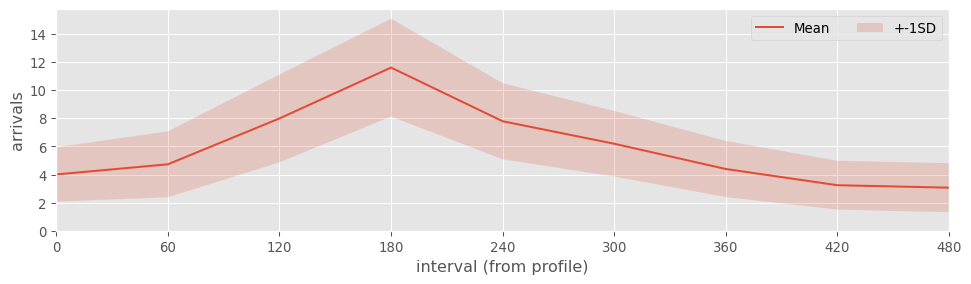

In [7]:
fig, ax = nspp_plot(data, run_length=540)

### Tabular NSPP data

The function `nspp_simulation` returns a `pd.DataFrame`. By default 1000 replications of the NSPP are run.  The run length can be specified, but if omitted it defaults to the last interval + interval width in the arrival profile.

In the Banks et al. example we are given the rate per minute of arrivals. We therefore multiply this by 60 get the expected number of arrivals in an hour.  We compare this to the actual simulated.

In [8]:
nspp_replications = nspp_simulation(data, n_reps=1000)

# peak at data
nspp_replications.head()

,0,1,2,3,4,5,6,7,8
rep,,,,,,,,,
1,1,5,7,13,9,11,5,3,1
2,6,7,4,9,6,8,5,1,3
3,3,2,6,13,4,6,2,1,5
4,4,2,8,10,7,7,5,1,9
5,2,4,10,13,10,7,8,4,5


In [9]:
# re-label columns
nspp_replications.columns = data["t"].values


## banks data converted from arrivasl per min to arrivals per hour
data["expected_mean_arrivals_hr"] = data["arrival_rate"] * 60.0
data["simulated_mean_arrivals_hr"] = nspp_replications.mean(axis=0).values
data.round(1)

,t,mean_iat,arrival_rate,expected_mean_arrivals_hr,simulated_mean_arrivals_hr
0,0,15,0.1,4.0,4.0
1,60,12,0.1,5.0,4.7
2,120,7,0.1,8.6,8.0
3,180,5,0.2,12.0,11.6
4,240,8,0.1,7.5,7.8
5,300,10,0.1,6.0,6.2
6,360,15,0.1,4.0,4.4
7,420,20,0.0,3.0,3.2
8,480,20,0.0,3.0,3.1
